# Advanced Usage of reLAISS
### Authors: Evan Reynolds and Alex Gagliano

## Introduction

This notebook demonstrates advanced features of the reLAISS library for finding similar astronomical transients. While the basic_usage.ipynb notebook covered the fundamental functionality, here we'll explore more sophisticated techniques that give you greater flexibility and power in your analysis.

These advanced features allow you to customize how reLAISS processes and analyzes data, including dimensionality reduction, theorized lightcurves, host galaxy swapping, fine-tuning of algorithm parameters, visualization tools, and advanced anomaly detection.

## Topics Covered
1. Using PCA for dimensionality reduction
2. Creating and using theorized lightcurves
3. Swapping host galaxies
4. Setting maximum neighbor distances
5. Tweaking ANNOY parameters
6. Making corner plots
7. Advanced anomaly detection with parameter tuning
8. Host swapping in anomaly detection

## Setup

First, let's import the necessary packages and create the required directories:

In [1]:
import os
import pandas as pd
import numpy as np
import relaiss as rl
import astropy.units as u
import matplotlib.pyplot as plt

# Create output directories
os.makedirs('./figures', exist_ok=True)
os.makedirs('./sfddata-master', exist_ok=True)
os.makedirs('./models', exist_ok=True)
os.makedirs('./timeseries', exist_ok=True)

def create_theorized_lightcurve():
    """Create a simple theorized lightcurve for demonstration."""
    # Create a simple Gaussian lightcurve
    times = np.linspace(-20, 50, 50)  # Days relative to peak
    g_mags = 18 - 5 * np.exp(-(times**2) / (2 * 15**2))  # Gaussian with peak at mag 18
    r_mags = 19 - 4 * np.exp(-(times**2) / (2 * 20**2))  # Gaussian with peak at mag 19
    
    # Create DataFrame in the format expected by reLAISS
    g_data = pd.DataFrame({
        'ant_mjd': times + 59000,  # Add offset to get realistic MJD values
        'ant_mag': g_mags,
        'ant_magerr': np.ones_like(times) * 0.1,  # Constant uncertainty
        'ant_passband': ['g'] * len(times),  # Antares passband
        'ant_ra': np.full_like(times, 180.0, dtype=float),  # RA in degrees
        'ant_dec': np.full_like(times, 45.0, dtype=float),  # Dec in degrees
    })
    
    r_data = pd.DataFrame({
        'ant_mjd': times + 59000,  # Add offset to get realistic MJD values
        'ant_mag': r_mags,
        'ant_magerr': np.ones_like(times) * 0.1,  # Constant uncertainty
        'ant_passband': ['R'] * len(times),  # Antares passband - R uppercase for r-band
        'ant_ra': np.full_like(times, 180.0, dtype=float),  # RA in degrees
        'ant_dec': np.full_like(times, 45.0, dtype=float),  # Dec in degrees
    })
    
    # Combine g and r band data
    lc_df = pd.concat([g_data, r_data], ignore_index=True)
    
    return lc_df

## Initialize the ReLAISS Client

We'll start by creating a ReLAISS client instance:

In [2]:
# Initialize the client
client_pca = rl.ReLAISS()

## 1. Using PCA for Dimensionality Reduction

PCA (Principal Component Analysis) can be used to reduce the dimensionality of the feature space while preserving most of the variance. This has several benefits:

- Improves search speed by reducing the computational complexity
- Potentially reduces noise in the feature space
- Helps mitigate the "curse of dimensionality" for high-dimensional data

To use PCA, we set `use_pca=True` in the `load_reference` method and specify the number of components to keep:

Loading preprocessed reference bank from cache...
Building search index...
No host features provided. Running lightcurve-only LAISS with 25 features.
Building new NGT index with 25515 transients...
Done!

Loading saved PCA model from /Users/alexgagliano/.relaiss/cache/indices/re_laiss_ngt_index_pcaTrue_10comps_25lc_0host_1weight_pca.joblib
Loading previously saved NGT PCA=10 index: /Users/alexgagliano/.relaiss/cache/indices/re_laiss_ngt_index_pcaTrue_10comps_25lc_0host_1weight.ngt 


Found input transient at index 0, removing it...

ANN elapsed time: 0.005 s
Total elapsed time: 0.005 s

         ZTF ID        IAU Name   Spec           z
INPUT:   ZTF21abbzjeq  2021mwb    SN Ia      0.043

Making a plot of stacked lightcurves...


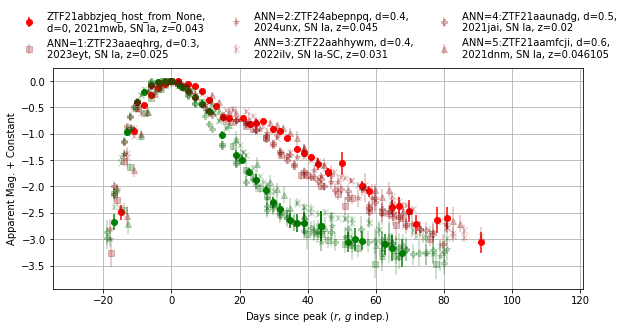


Generating hosts grid plot...


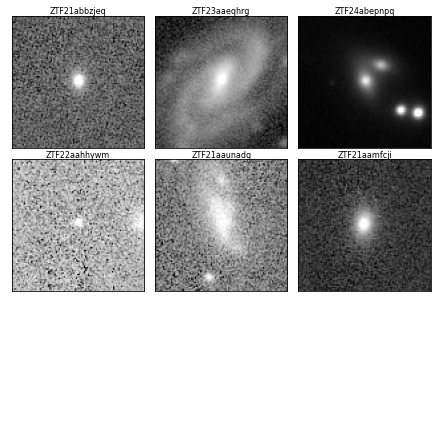

ANN# ZTF ID        IAU Name Spec             z   Dist  Link
1    ZTF23aaeqhrg  2023eyt  SN Ia        0.025  0.304  https://alerce.online/object/ZTF23aaeqhrg
2    ZTF24abepnpq  2024unx  SN Ia        0.045  0.397  https://alerce.online/object/ZTF24abepnpq
3    ZTF22aahhywm  2022ilv  SN Ia-SC     0.031  0.405  https://alerce.online/object/ZTF22aahhywm
4    ZTF21aaunadg  2021jai  SN Ia        0.020  0.535  https://alerce.online/object/ZTF21aaunadg
5    ZTF21aamfcji  2021dnm  SN Ia        0.046  0.613  https://alerce.online/object/ZTF21aamfcji


In [3]:
client_pca.load_reference(
    path_to_sfd_folder='./sfddata-master',
    use_pca=True,
    host_features=[],
    num_pca_components=10,
    force_recreation_of_index=True
)

neighbors_df = client_pca.find_neighbors(
    ztf_object_id='ZTF21abbzjeq',
    n=5,
    search_k=-1,
    plot=True,
    save_figures=False,
    path_to_figure_directory='./figures'
)

## 2. Creating and Using Theorized Lightcurves

One powerful feature of reLAISS is the ability to use theorized (synthetic) lightcurves in the neighbor search. This allows you to test theoretical models against observed data.

When creating a theorized lightcurve, the DataFrame should have the following columns:
- `ant_mjd`: Modified Julian Date (time)
- `ant_mag`: Magnitude
- `ant_magerr`: Magnitude error
- `ant_passband`: Filter name ('g' for g-band, 'R' for r-band)
- `ant_ra`: Right Ascension (optional)
- `ant_dec`: Declination (optional)

**Important:** When using a theorized lightcurve, you must also provide a `host_ztf_id` parameter to specify which host galaxy to use, since the theorized lightcurve doesn't have an associated host.

Below, we create a simple Gaussian-shaped lightcurve and find its nearest neighbors:

Loading preprocessed reference bank from cache...
Building search index...
Loading previously saved NGT index...
Done!

Using provided preprocessed dataframe to extract time series features...
Extracted lightcurve features for theorized lightcurve in 2.36s!
Using provided preprocessed dataframe instead of processing raw data
Loading previously saved ngt index without PCA: /Users/alexgagliano/.relaiss/cache/indices/re_laiss_ngt_index_pcaFalse_25lc_8host_1weight.ngt 


ANN elapsed time: 0.008 s
Total elapsed time: 0.008 s

         ZTF ID        IAU Name   Spec           z
INPUT:   [model]       No TNS     ---      -99.000
HOST:    ZTF23abaeenk  2023rpk    SN II      0.035

Making a plot of stacked lightcurves...
Saved lightcurve plot to:./figures/lightcurves/theorized_lc_host_from_ZTF23abaeenk.png


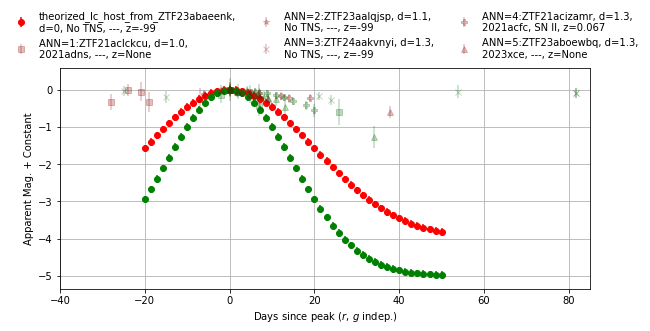


Generating hosts grid plot...


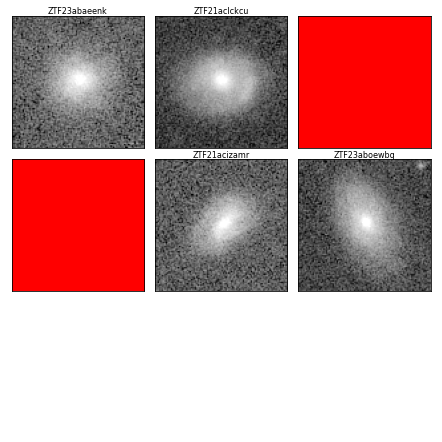

PDF written to figures/host_grids/theorized_lc_host_from_ZTF23abaeenk_host_thumbnails_ann=5.pdf

ANN# ZTF ID        IAU Name Spec             z   Dist  Link
1    ZTF21aclckcu  2021adns ---        ---  0.987  https://alerce.online/object/ZTF21aclckcu
2    ZTF23aalqjsp  No TNS   ---        -99.000  1.129  https://alerce.online/object/ZTF23aalqjsp
3    ZTF24aakvnyi  No TNS   ---        -99.000  1.266  https://alerce.online/object/ZTF24aakvnyi
4    ZTF21acizamr  2021acfc SN II        0.067  1.269  https://alerce.online/object/ZTF21acizamr
5    ZTF23aboewbq  2023xce  ---        ---  1.278  https://alerce.online/object/ZTF23aboewbq


In [4]:
client_theor = rl.ReLAISS()

client_theor.load_reference(
    path_to_sfd_folder='./sfddata-master',  # Directory for SFD dust maps
    use_pca=False,  # Don't use PCA for this example
    host_features= ["gKronMagCorrected", "gKronRad", "gExtNSigma",  "rKronMagCorrected",  "rKronRad",  "iKronMagCorrected", "zKronMagCorrected", "zKronRad"],
)

# Create a theorized lightcurve
theorized_lc = create_theorized_lightcurve()

# Find neighbors for the theorized lightcurve
# Need to provide a host galaxy when using theorized lightcurve
neighbors_df = client_theor.find_neighbors(
    theorized_lightcurve_df=theorized_lc,
    host_ztf_id='ZTF23abaeenk',
    n=5,
    plot=True,
    save_figures=True,
    path_to_figure_directory='./figures'
)

## 3. Swapping Host Galaxies

reLAISS allows you to swap the host galaxy of a transient, which is useful for:

- Exploring how host properties affect the similarity search results
- Investigating the effects of different environments on transient characteristics
- Testing hypotheses about host galaxy influences

Here's how to swap in a different host galaxy:

Preprocessing reference bank...
Loading preprocessed features from cache...
Caching preprocessed reference bank...
Building search index...
Loading previously saved NGT index...
Done!

Using provided preprocessed dataframe to extract time series features...
Extracted lightcurve features for ZTF19aazefbe in 6.10s!
Searching for host galaxy...
Using provided preprocessed dataframe instead of processing raw data
Loading previously saved ngt index without PCA: /Users/alexgagliano/.relaiss/cache/indices/re_laiss_ngt_index_pcaFalse_25lc_19host_1weight.ngt 


ANN elapsed time: 0.012 s
Total elapsed time: 0.012 s

         ZTF ID        IAU Name   Spec           z
INPUT:   ZTF21abbzjeq  2021mwb    SN Ia      0.043
HOST:    ZTF19aazefbe  No TNS     ---      -99.000

Making a plot of stacked lightcurves...
Saved lightcurve plot to:./figures/lightcurves/ZTF21abbzjeq_host_from_ZTF19aazefbe.png


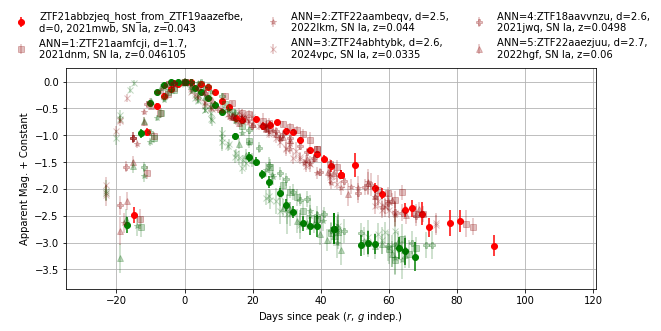


Generating hosts grid plot...


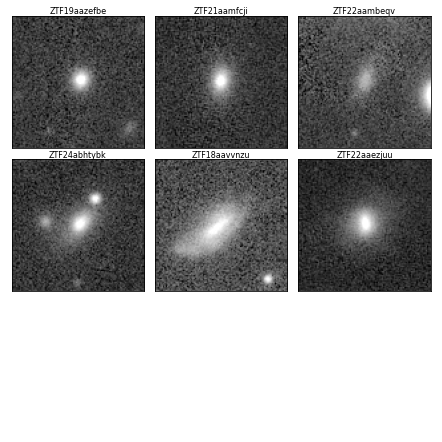

PDF written to figures/host_grids/ZTF21abbzjeq_host_from_ZTF19aazefbe_host_thumbnails_ann=5.pdf

ANN# ZTF ID        IAU Name Spec             z   Dist  Link
1    ZTF21aamfcji  2021dnm  SN Ia        0.046  1.679  https://alerce.online/object/ZTF21aamfcji
2    ZTF22aambeqv  2022lkm  SN Ia        0.044  2.472  https://alerce.online/object/ZTF22aambeqv
3    ZTF24abhtybk  2024vpc  SN Ia        0.034  2.606  https://alerce.online/object/ZTF24abhtybk
4    ZTF18aavvnzu  2021jwq  SN Ia        0.050  2.611  https://alerce.online/object/ZTF18aavvnzu
5    ZTF22aaezjuu  2022hgf  SN Ia        0.060  2.677  https://alerce.online/object/ZTF22aaezjuu


In [5]:
# Find neighbors with a swapped host galaxy
client = rl.ReLAISS()

client.load_reference(
    path_to_sfd_folder='./sfddata-master',  # Directory for SFD dust maps
)

neighbors_df = client.find_neighbors(
    ztf_object_id='ZTF21abbzjeq',  # Source transient
    host_ztf_id='ZTF19aazefbe',  # Host to swap in
    n=5,
    plot=True,
    save_figures=True,
    path_to_figure_directory='./figures'
)

## 4. Setting Maximum Neighbor Distances

Sometimes you're only interested in neighbors that are truly similar to your target. By setting a maximum distance threshold, you can:

- Filter out neighbors that are too dissimilar
- Focus only on highly confident matches

Note that you might get fewer neighbors than requested if the distance threshold is applied:

There are host features, snagging from the light curve ID!
Loading previously saved ngt index without PCA: /Users/alexgagliano/.relaiss/cache/indices/re_laiss_ngt_index_pcaFalse_25lc_19host_1weight.ngt 


Found input transient at index 0, removing it...

ANN elapsed time: 0.015 s
Total elapsed time: 0.015 s

Found 10 neighbors for distance threshold of 6.
         ZTF ID        IAU Name   Spec           z
INPUT:   ZTF21abbzjeq  2021mwb    SN Ia      0.043

Making a plot of stacked lightcurves...
Lightcurve plotter only plots up to 8 neighbors. Stopping at neighbor 8.
Saved lightcurve plot to:./figures/lightcurves/ZTF21abbzjeq.png


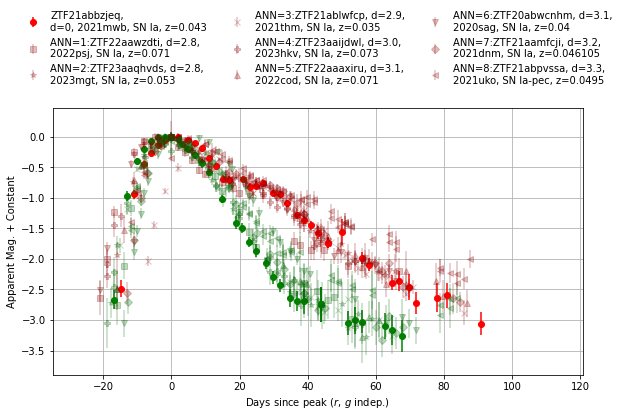


Generating hosts grid plot...


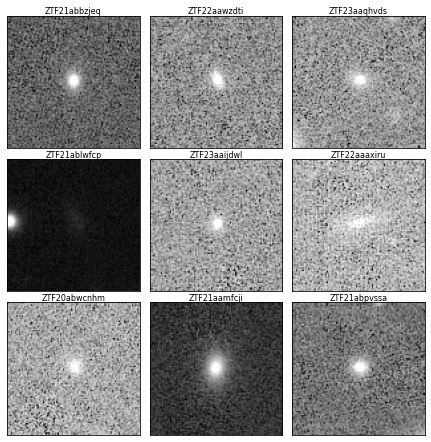

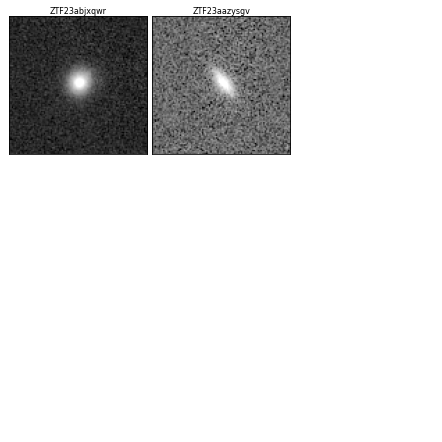

PDF written to figures/host_grids/ZTF21abbzjeq_host_thumbnails_ann=10.pdf

ANN# ZTF ID        IAU Name Spec             z   Dist  Link
1    ZTF22aawzdti  2022psj  SN Ia        0.071  2.792  https://alerce.online/object/ZTF22aawzdti
2    ZTF23aaqhvds  2023mgt  SN Ia        0.053  2.847  https://alerce.online/object/ZTF23aaqhvds
3    ZTF21ablwfcp  2021thm  SN Ia        0.035  2.939  https://alerce.online/object/ZTF21ablwfcp
4    ZTF23aaijdwl  2023hkv  SN Ia        0.073  3.004  https://alerce.online/object/ZTF23aaijdwl
5    ZTF22aaaxiru  2022cod  SN Ia        0.071  3.070  https://alerce.online/object/ZTF22aaaxiru
6    ZTF20abwcnhm  2020sag  SN Ia        0.040  3.072  https://alerce.online/object/ZTF20abwcnhm
7    ZTF21aamfcji  2021dnm  SN Ia        0.046  3.174  https://alerce.online/object/ZTF21aamfcji
8    ZTF21abpvssa  2021uko  SN Ia-pec    0.050  3.285  https://alerce.online/object/ZTF21abpvssa
9    ZTF23abjxqwr  2023vtp  SN Ia-91T-   0.042  3.332  https://alerce.online/object/ZTF23

In [6]:
# Find neighbors with maximum distance constraint
neighbors_df = client.find_neighbors(
    ztf_object_id='ZTF21abbzjeq',
    n=10,
    max_neighbor_dist=6,  # Only return neighbors within this distance
    plot=True,
    save_figures=True,
    path_to_figure_directory='./figures'
)

print(f"Number of neighbors found: {len(neighbors_df)}")

## 6. Making Corner Plots

Corner plots are a powerful visualization tool that show the distribution of features for the input transient and its neighbors. They can help you:

- Understand which features are driving the similarity matching
- Identify potential correlations between different features
- Visualize the feature space and where your transient sits within it

To create corner plots, we need to first get the primer_dict containing information about the input transient:

There are host features, snagging from the light curve ID!
Loading previously saved ngt index without PCA: /Users/alexgagliano/.relaiss/cache/indices/re_laiss_ngt_index_pcaFalse_25lc_19host_1weight.ngt 


Found input transient at index 0, removing it...

ANN elapsed time: 0.013 s
Total elapsed time: 0.013 s

         ZTF ID        IAU Name   Spec           z
INPUT:   ZTF21abbzjeq  2021mwb    SN Ia      0.043

Making a plot of stacked lightcurves...
Saved lightcurve plot to:./figures/lightcurves/ZTF21abbzjeq.png


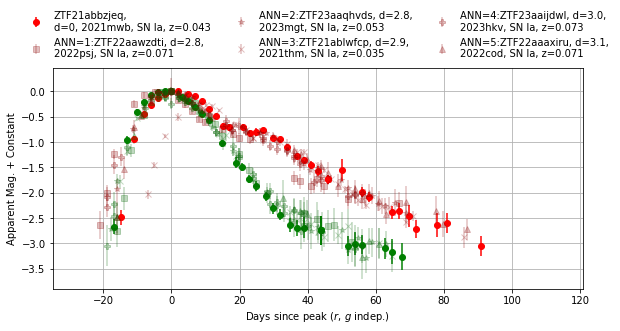


Generating hosts grid plot...


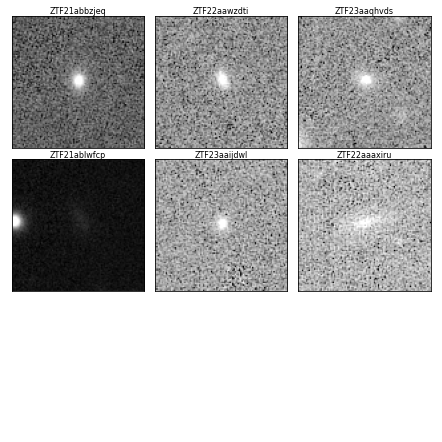

PDF written to figures/host_grids/ZTF21abbzjeq_host_thumbnails_ann=5.pdf

ANN# ZTF ID        IAU Name Spec             z   Dist  Link
1    ZTF22aawzdti  2022psj  SN Ia        0.071  2.792  https://alerce.online/object/ZTF22aawzdti
2    ZTF23aaqhvds  2023mgt  SN Ia        0.053  2.847  https://alerce.online/object/ZTF23aaqhvds
3    ZTF21ablwfcp  2021thm  SN Ia        0.035  2.939  https://alerce.online/object/ZTF21ablwfcp
4    ZTF23aaijdwl  2023hkv  SN Ia        0.073  3.004  https://alerce.online/object/ZTF23aaijdwl
5    ZTF22aaaxiru  2022cod  SN Ia        0.071  3.070  https://alerce.online/object/ZTF22aaaxiru
There are host features, snagging from the light curve ID!
Using provided preprocessed dataframe for corner plots
Total number of transients for corner plots: 25515
Creating corner plot for lc_group_1...
Total number of transients for corner plot after outlier removal: 18631


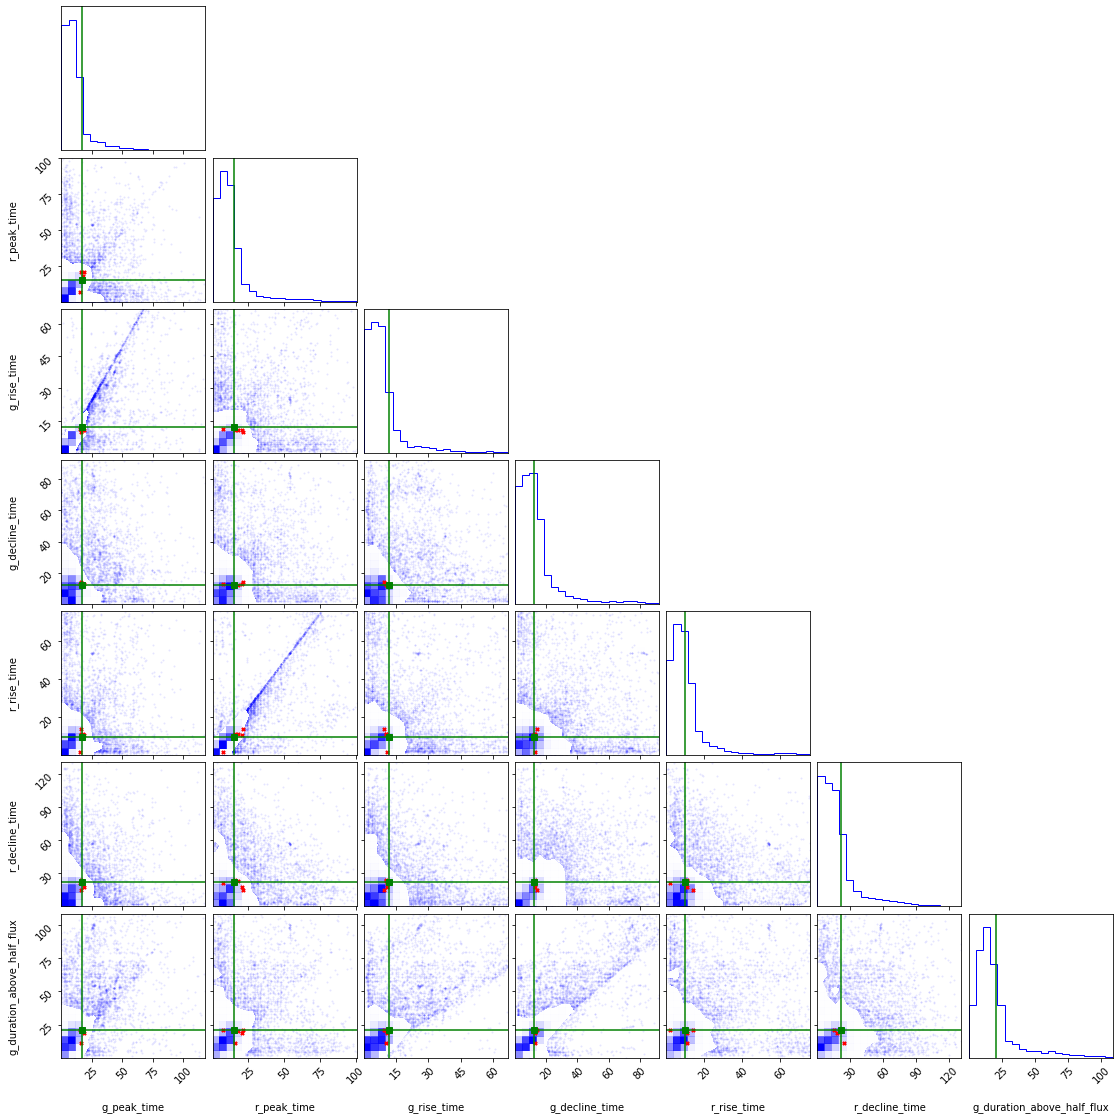

Creating corner plot for lc_group_2...
Total number of transients for corner plot after outlier removal: 22583


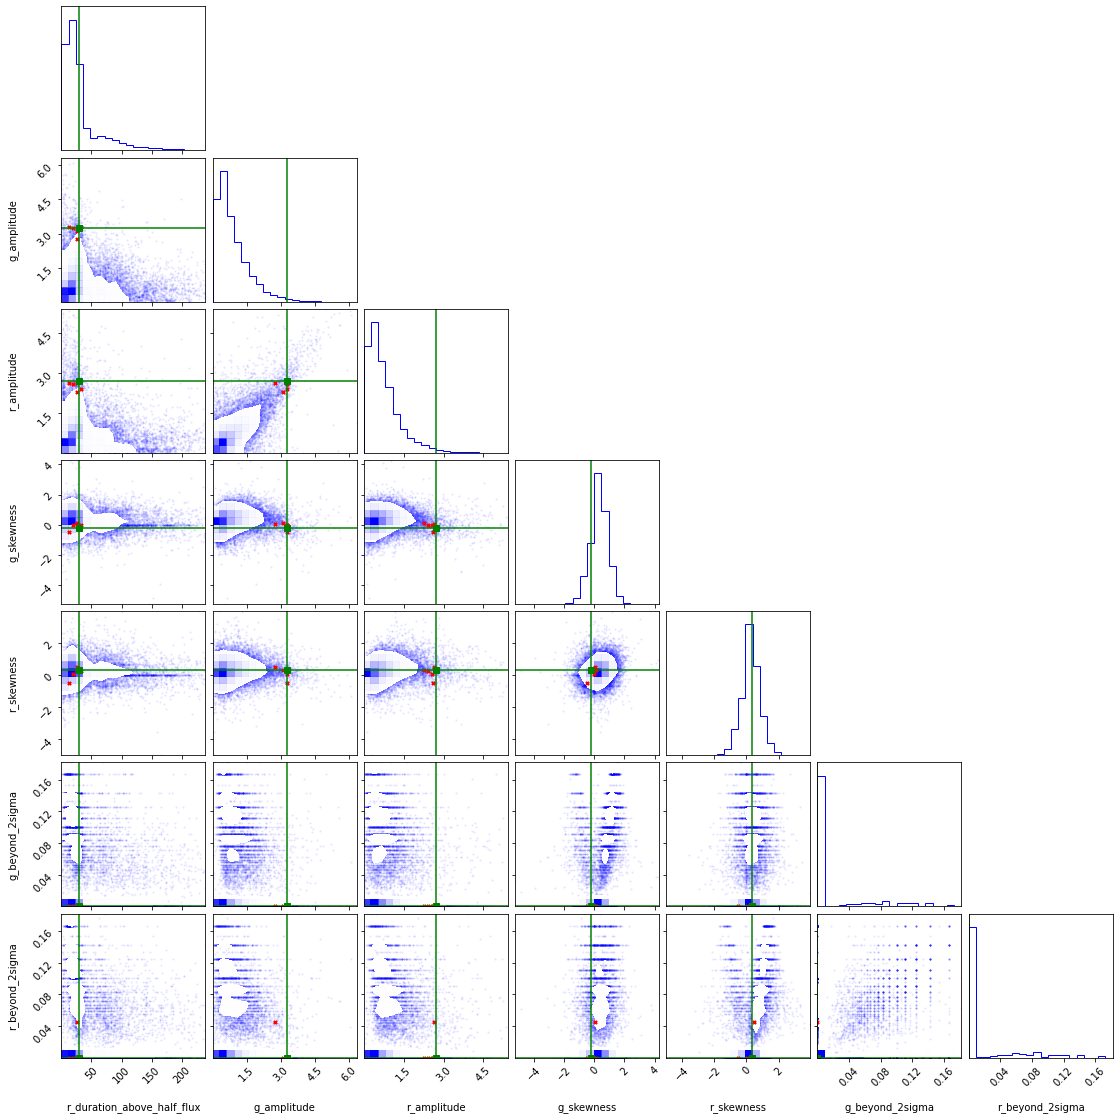

Creating corner plot for lc_group_3...
Total number of transients for corner plot after outlier removal: 21075


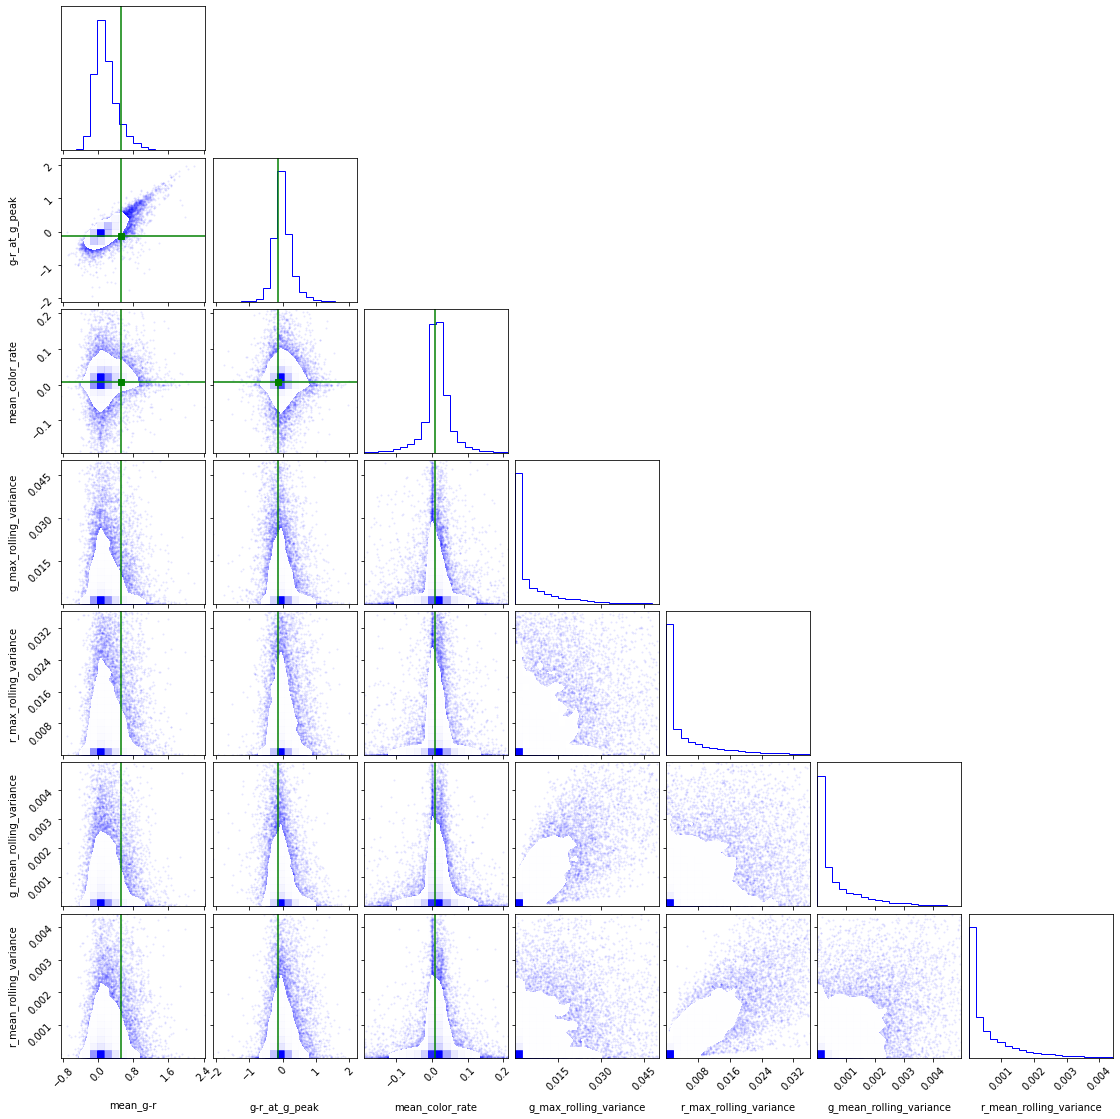

Creating corner plot for lc_group_4...
Total number of transients for corner plot after outlier removal: 22969


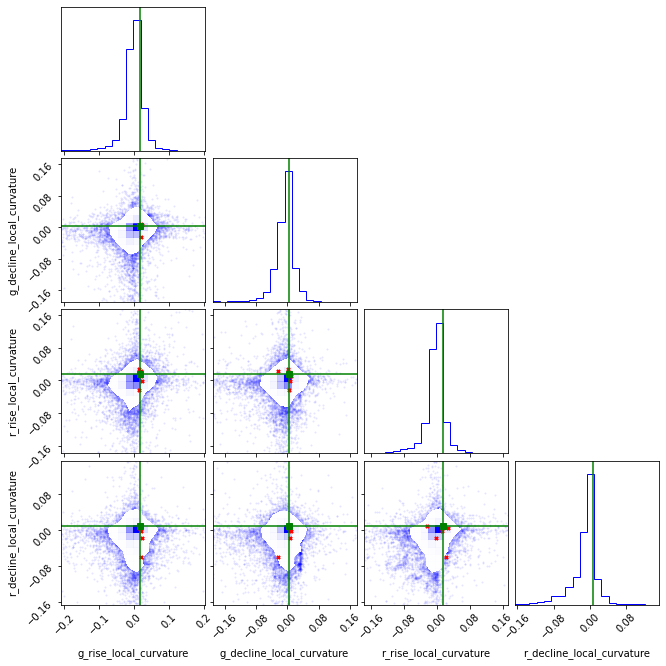

Creating corner plot for host_group_1...
Total number of transients for corner plot after outlier removal: 24959


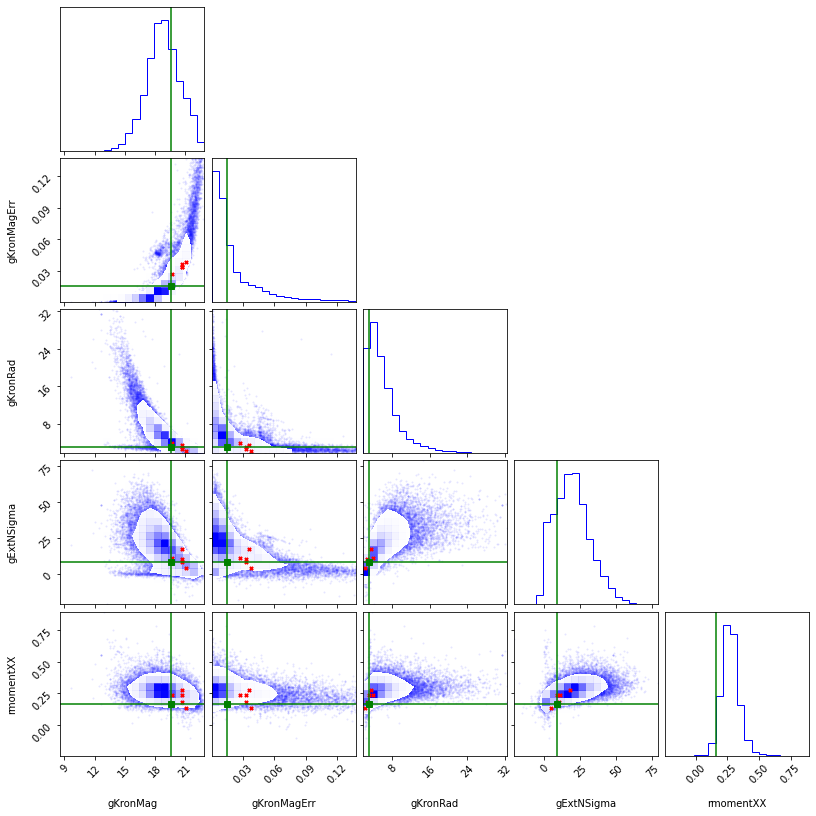

Creating corner plot for host_group_2...
Total number of transients for corner plot after outlier removal: 24851


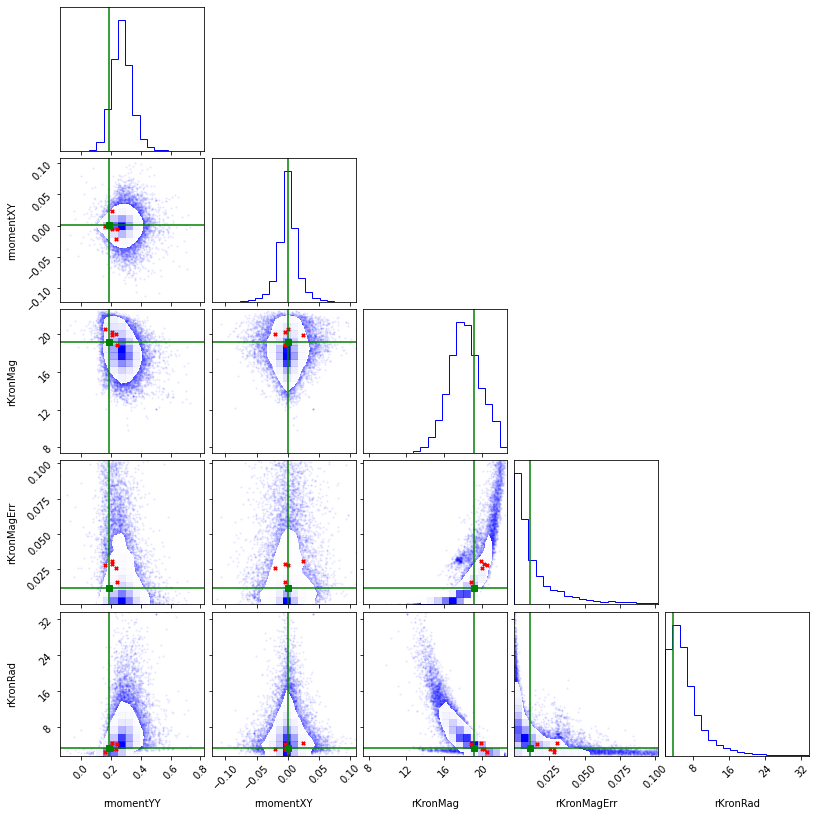

Creating corner plot for host_group_3...
Total number of transients for corner plot after outlier removal: 24836


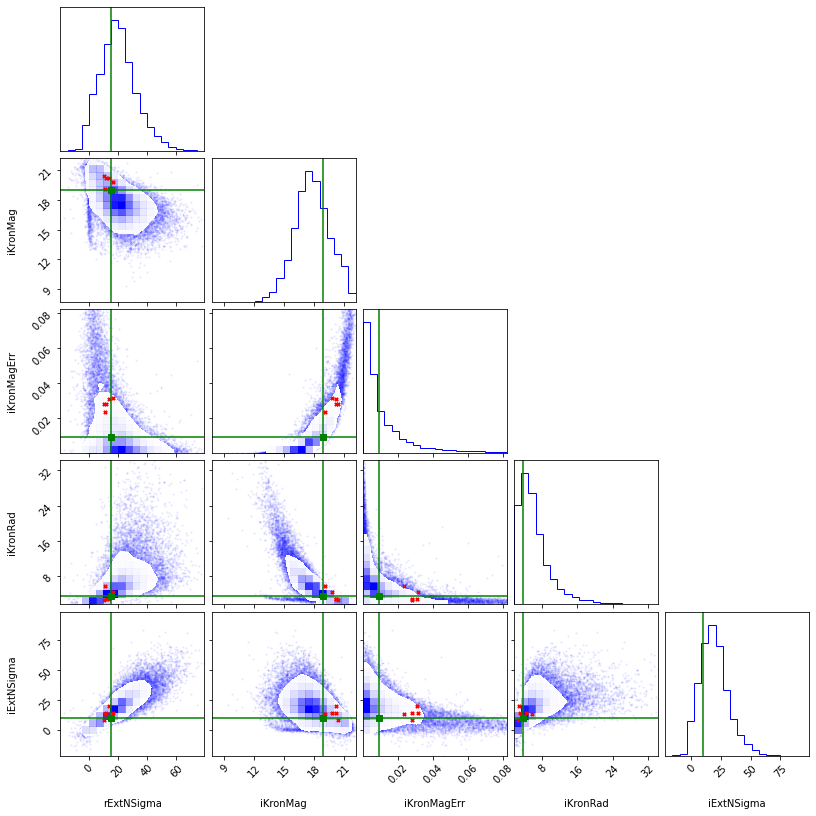

Creating corner plot for host_group_4...
Total number of transients for corner plot after outlier removal: 24944


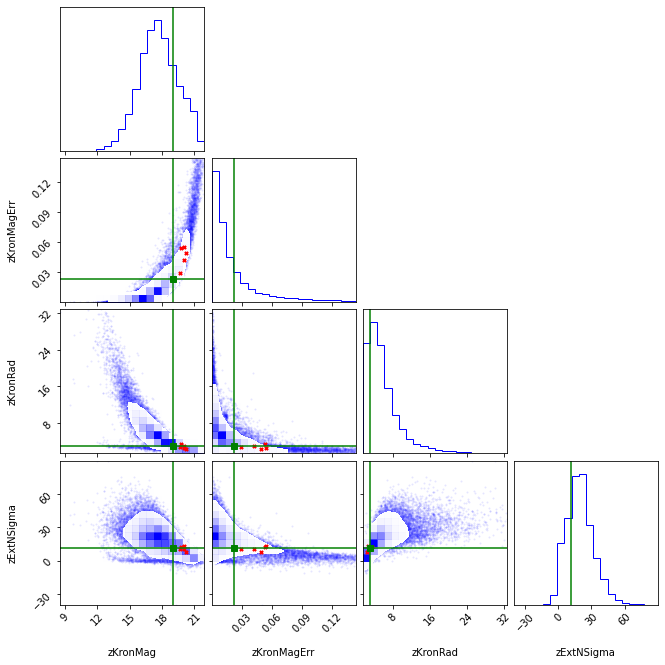

Corner plots saved to./figures/corner_plots
Corner plots saved to ./figures/


In [7]:
# Get neighbors from a new search
neighbors_df = client.find_neighbors(
    ztf_object_id='ZTF21abbzjeq',
    n=5,
    plot=True,
    save_figures=True,
    path_to_figure_directory='./figures'
)

# Get primer_dict separately
from relaiss.search import primer
primer_dict = primer(
    lc_ztf_id='ZTF21abbzjeq',
    theorized_lightcurve_df=None,
    host_ztf_id=None,
    dataset_bank_path=client.bank_csv,
    path_to_timeseries_folder='./',
    path_to_sfd_folder=client.path_to_sfd_folder,
    lc_features=client.lc_features,
    host_features=client.host_features,
    num_sims=0,
    save_timeseries=False,
    preprocessed_df=client.get_preprocessed_dataframe()  # Use the preprocessed dataframe
)

# Create corner plots using the primer_dict
from relaiss.plotting import corner_plot
corner_plot(
    neighbors_df=neighbors_df,
    primer_dict=primer_dict,
    path_to_dataset_bank=client.bank_csv,
    path_to_figure_directory='./figures',
    save_plots=True,
    preprocessed_df=client.get_preprocessed_dataframe()  # Use the preprocessed dataframe
)
print("Corner plots saved to ./figures/")

## Conclusion

By combining these features, you can create highly customized searches tailored to your specific research questions.

For information on how to build your own dataset bank for reLAISS, see the `build_databank.ipynb` notebook.